In [3]:

# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

import matplotlib.pyplot as plt

In [4]:
def make_system(Tenv, K1, C1, D1, K2, C2, D2, K3, C3, D3, depth, delta, dt, side_length, ML, CL):
    """Make a system object for the Lizard model.
    returns: System object
    """
    init = State(Lay1=26.7, Lay2=26.7, Lay3=26.7, L= 26.7)  
    
    t0 = 0
    t_end = 100000*(1/dt) #in seconds
    dt = dt

    return System(init=init, t0=t0, t_end=t_end, 
                  Tenv=Tenv, K1=K1, K2=K2, K3=K3,
                  depth=depth, delta=delta, dt=dt, 
                  side_length=side_length, C1=C1, 
                  C2=C2, C3=C3, CL=CL, D1 = D1, D2=D2, 
                  D3=D3, ML=ML)

In [5]:
def update_func(state, t, system):
    """Update the model.  
    returns: State ()     
    """
    unpack(system)
    lay1, lay2, lay3, l = state
   
    #The below four diff EQs represent the rate of heat changing 
    #between the outer layer to the inner layer(lizard)"""

    d1dt = K1*(side_length**3)*(Tenv-lay1)/depth      
    d2dt = K2*((side_length-.0127)**3)*(lay1-lay2)/depth
    d3dt = K3*((side_length-.0254)**3)*(lay2-lay3)/depth
    dLdt = ((side_length-.0381)**3)*0.5*(lay3-l)/(delta/2)
    
    lay1 += (d1dt/(C1*(D1*(side_length**3-(side_length-0.0127)**3))))*dt #these update the temps of each layer
    lay2 += (d2dt/(C2*(D2*((side_length-.0127)**3-(side_length-0.0254)**3))))*dt
    lay3 += (d3dt/(C3*(D3*((side_length-.0254)**3-(side_length-0.381)**3))))*dt
    l += (dLdt/(CL*ML))*dt

    return State(Lay1=lay1, Lay2=lay2, Lay3=lay3, L=l)

In [6]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.     
    system: System object
    update_func: function that updates state    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    return frame.L

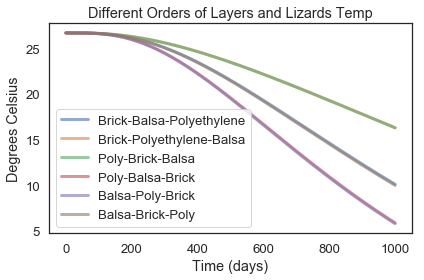

In [5]:
system = make_system(-10, 1.31, 840, 1900, .048, 1500, 160, 0.33, 1250, 561, .0127, .0762, 100, .2032, 0.899, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Brick-Balsa-Polyethylene')

system = make_system(-10, 1.31, 840, 1900, 0.33, 1250, 561, .048, 1500, 160, .0127, .0762, 100, .2032, 0.899, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Brick-Polyethylene-Balsa')

system = make_system(-10, 0.33, 1250, 561, 1.31, 840, 1900, .048, 1500, 160, .0127, .0762, 100, .2032, 0.899, 3762) 
results = run_simulation(system, update_func)
plot(results, label = 'Poly-Brick-Balsa')

system = make_system(-10, 0.33, 1250, 561, .048, 1500, 160, 1.31, 840, 1900, .0127, .0762, 100, .2032, 0.899, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Poly-Balsa-Brick')

system = make_system(-10, .048, 1500, 160, 0.33, 1250, 561, 1.31, 840, 1900, .0127, .0762, 100, .2032, 0.899, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Balsa-Poly-Brick')

system = make_system(-10, .048, 1500, 160, 1.31, 840, 1900, 0.33, 1250, 561, .0127, .0762, 100, .2032, 0.899, 3762)
results = run_simulation(system, update_func)
plot(results, label = 'Balsa-Brick-Poly')

decorate(xlabel='Time (days)',
         ylabel='Degrees Celsius',
         title = 'Different Orders of Layers and Lizards Temp')

In [14]:
def run_simulation_1(system, update_func):
    """Runs a simulation of the system.     
    system: System object
    update_func: function that updates state    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, 86400):
        frame.row[t+1] = update_func(frame.row[t], t, system)
        if frame.L[t+1]<=25:
            cold.cold+=1
        if cold.cold >= (21600/dt):
            return t
    return -1

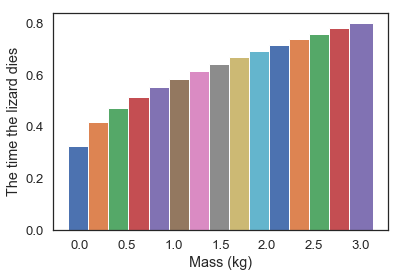

In [24]:
mass = SweepSeries()
width =0.25
for m in linspace(0.0016, 3, 15):
    cold = State(cold=0)
    system = make_system(-10, 10.9, 800, 2500, 0.33, 1250, 561, .048, 1500, 160, .0127, .0762, 100, .2032, m, 3762) 
    mass[m] = run_simulation_1(system, update_func)
    p1 = plt.bar(m, mass[m], width)
plt.xlabel('Mass (kg)')
plt.ylabel('The time the lizard dies')

plt.show()